In [2]:
# general:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV       # hyperparam selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef  # matric for performance evaluation in training
# self-written:
import data_cleaner as dc  # self-writtten data cleaning functions
import ML_func as ml       # self-written ML related functions
pd.set_option('display.max_rows', 500)  # let pd.df display() 500 rows
pd.set_option('display.max_columns', 500)

# Import data & pre-processing

In [3]:
# imputed:  use 1 data to build pipeline first
x_train = pd.read_csv("../clean_data/mci_wv1go_imp.csv")   # use imputed data
x_test = pd.read_csv("../clean_data/mci_wv23_imp.csv")   
y_train = x_train.pop("progress")
y_test = x_test.pop("progress")
x_train, train_imp_mean_sd = dc.standardization(x_train)
x_test, test_imp_mean_sd = dc.standardization(x_test)

In [4]:
# # rm variables: for interpretation
x_test.drop(["FSVERSION"], axis=1, inplace=True)
x_train.drop(["FSVERSION"], axis=1, inplace=True)
cat_cols = x_train.apply(lambda x : (x.dtype=="int64") and (len(x.unique())<5) )
cat_cols = x_train.columns[cat_cols].to_list()
x_train = pd.get_dummies(x_train, columns=cat_cols)
x_test = pd.get_dummies(x_test, columns=cat_cols)
# x_test.columns[~pd.Series(x_test.columns).isin(x_train.columns)]    
# x_train.columns[~pd.Series(x_train.columns).isin(x_test.columns)]   
# # -> all variables exist in both groups

# # change colnames for labeling:
newnm = pd.Series(x_train.columns)
newnm[newnm.str.contains("_UPENN")]
newnm[44:47] = ['ABETA', 'TAU', 'PTAU']
x_test.columns = x_train.columns = newnm

### XGBoost

In [657]:
import xgboost as xgb
# hyperparameter selection: 
params = {
    'gamma':[0,0.01,0.1],
    'lambda':[0,1,2],                # L2 regularization
    'eta':[0.05, 0.1, 0.3],          # learning rate
    'max_depth':[1,3,6],             # tree depth 
    'tree_method':["exact", "hist"]
}
mod_xgb = xgb.XGBClassifier(booster="gbtree", objective='binary:logistic', seed=1)  
cv_xgb = GridSearchCV(
    estimator = mod_xgb, 
    param_grid=params,
    cv=5, verbose=5,     # use 5-fold due to # of hyperparams
    scoring = 'matthews_corrcoef'  # because outcome imbalanced
)
cv_xgb.fit(x_train, y_train)       

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END ....gamma=0, lambda=0, max_depth=1;, score=0.370 total time=   0.1s
[CV 2/5] END ....gamma=0, lambda=0, max_depth=1;, score=0.134 total time=   0.1s
[CV 3/5] END ....gamma=0, lambda=0, max_depth=1;, score=0.397 total time=   0.1s
[CV 4/5] END ....gamma=0, lambda=0, max_depth=1;, score=0.513 total time=   0.1s
[CV 5/5] END ....gamma=0, lambda=0, max_depth=1;, score=0.371 total time=   0.1s
[CV 1/5] END ....gamma=0, lambda=0, max_depth=3;, score=0.268 total time=   0.2s
[CV 2/5] END ....gamma=0, lambda=0, max_depth=3;, score=0.163 total time=   0.2s
[CV 3/5] END ....gamma=0, lambda=0, max_depth=3;, score=0.316 total time=   0.2s
[CV 4/5] END ....gamma=0, lambda=0, max_depth=3;, score=0.547 total time=   0.2s
[CV 5/5] END ....gamma=0, lambda=0, max_depth=3;, score=0.413 total time=   0.1s
[CV 1/5] END ....gamma=0, lambda=0, max_depth=6;, score=0.313 total time=   0.2s
[CV 2/5] END ....gamma=0, lambda=0, max_depth=6

[CV 2/5] END ..gamma=0.1, lambda=0, max_depth=6;, score=0.102 total time=   0.2s
[CV 3/5] END ..gamma=0.1, lambda=0, max_depth=6;, score=0.434 total time=   0.2s
[CV 4/5] END ..gamma=0.1, lambda=0, max_depth=6;, score=0.493 total time=   0.2s
[CV 5/5] END ..gamma=0.1, lambda=0, max_depth=6;, score=0.263 total time=   0.2s
[CV 1/5] END ..gamma=0.1, lambda=1, max_depth=1;, score=0.327 total time=   0.1s
[CV 2/5] END ..gamma=0.1, lambda=1, max_depth=1;, score=0.178 total time=   0.1s
[CV 3/5] END ..gamma=0.1, lambda=1, max_depth=1;, score=0.375 total time=   0.1s
[CV 4/5] END ..gamma=0.1, lambda=1, max_depth=1;, score=0.514 total time=   0.1s
[CV 5/5] END ..gamma=0.1, lambda=1, max_depth=1;, score=0.371 total time=   0.1s
[CV 1/5] END ..gamma=0.1, lambda=1, max_depth=3;, score=0.268 total time=   0.2s
[CV 2/5] END ..gamma=0.1, lambda=1, max_depth=3;, score=0.208 total time=   0.2s
[CV 3/5] END ..gamma=0.1, lambda=1, max_depth=3;, score=0.397 total time=   0.2s
[CV 4/5] END ..gamma=0.1, la

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_lambda,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.181083,0.011205,0.003181,0.000136,0.01,1,3,"{'gamma': 0.01, 'lambda': 1, 'max_depth': 3}",0.267607,0.192336,0.513427,0.566442,0.413494,0.390661,0.142103,1
4,0.182780,0.021943,0.003403,0.000374,0,1,3,"{'gamma': 0, 'lambda': 1, 'max_depth': 3}",0.216661,0.192336,0.513427,0.566442,0.413494,0.380472,0.152040,2
19,0.170958,0.010933,0.003198,0.000194,0.1,0,3,"{'gamma': 0.1, 'lambda': 0, 'max_depth': 3}",0.267607,0.163187,0.391211,0.609800,0.370729,0.360507,0.148835,3
2,0.236724,0.028452,0.003561,0.000332,0,0,6,"{'gamma': 0, 'lambda': 0, 'max_depth': 6}",0.312960,0.101630,0.534947,0.513754,0.324315,0.357521,0.157770,4
18,0.091490,0.007379,0.003031,0.000230,0.1,0,1,"{'gamma': 0.1, 'lambda': 0, 'max_depth': 1}",0.370337,0.134324,0.397397,0.512719,0.370729,0.357101,0.123151,5


In [681]:
max_iterator = 500   # num of max trees
xgb_params = ml.vote_hyperparam(cv_xgb.cv_results_, top_n=5)  # top 5 mods vote for hyperparam
xgb_params["eta"] = 0.1
print(xgb_params)
# check learning curve to find best iteration:
best_it = []
for i in range(5):
    xgb_train, xgb_validate, o_train, o_validate = train_test_split(
        x_train, y_train, train_size=0.8, stratify=y_train, random_state = i*10)
    mod_xgb = xgb.XGBClassifier(booster="gbtree", objective='binary:logistic', 
                                eval_metric = 'logloss',
                                random_state=i, early_stopping_rounds = max_iterator//10,
                                n_estimators= max_iterator, 
                                **xgb_params  # use ** to unpack dict
                               ) 
    mod_xgb.fit(xgb_train, o_train, verbose=0,
                eval_set=[(xgb_train, o_train), (xgb_validate, o_validate)]) 
    results = mod_xgb.evals_result()
    best_it.append(mod_xgb.best_iteration)
#     plt.figure(figsize=(4,3))
#     plt.plot(results["validation_0"]["logloss"], label="Training loss")
#     plt.plot(results["validation_1"]["logloss"], label="Validation loss")
#     plt.axvline(best_it[-1], color="gray", label="Optimal tree number")
#     plt.xlabel("Number of trees")
#     plt.ylabel("Loss")
#     plt.legend()
print(f"Best iteration for each round: {best_it}; mean={sum(best_it)/5}")
xgb_it = round(sum(best_it)/5)  

{'gamma': 0, 'lambda': 0, 'max_depth': 3, 'eta': 0.1}
Best iteration for each round: [40, 95, 64, 50, 60]; mean=61.8


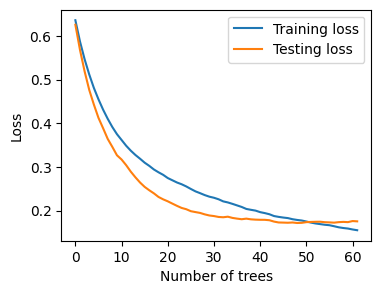

In [682]:
mod_xgb = xgb.XGBClassifier(booster="gbtree", objective='binary:logistic', 
                                eval_metric = 'logloss',
                                random_state=77,
                                n_estimators= xgb_it,    # 
                                **xgb_params  # use ** to unpack dict
                               ) 
mod_xgb.fit(x_train, y_train, verbose=0,
            eval_set=[(x_train, y_train), (x_test, y_test)])
results = mod_xgb.evals_result()
plt.figure(figsize=(4,3))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Testing loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [669]:
result_xgb = {'train_pred':mod_xgb.predict(x_train), 
              'train_prob':mod_xgb.predict_proba(x_train)[:,1],
              'test_pred':mod_xgb.predict(x_test), 
              'test_prob':mod_xgb.predict_proba(x_test)[:,1]}
dc.save_py(result_xgb, "output/result_xgb_imp")
# dc.load_py("output/result_xgb.pkl")


### Interpretation

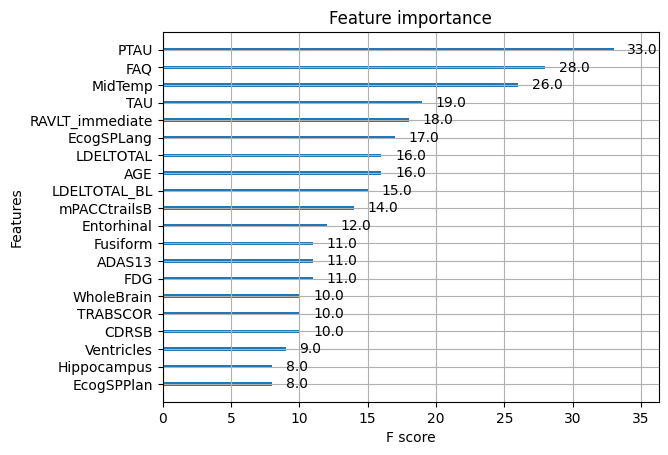

In [687]:
import matplotlib.pyplot as plt
xgb.plot_importance(mod_xgb, max_num_features=20, importance_type="weight")
xgb_feat = mod_xgb.get_booster().get_score(importance_type="weight")
xgb_feat = {key:item/xgb_it for key,item in xgb_feat.items()}
dc.save_py(xgb_feat, "output/xgb_feat")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


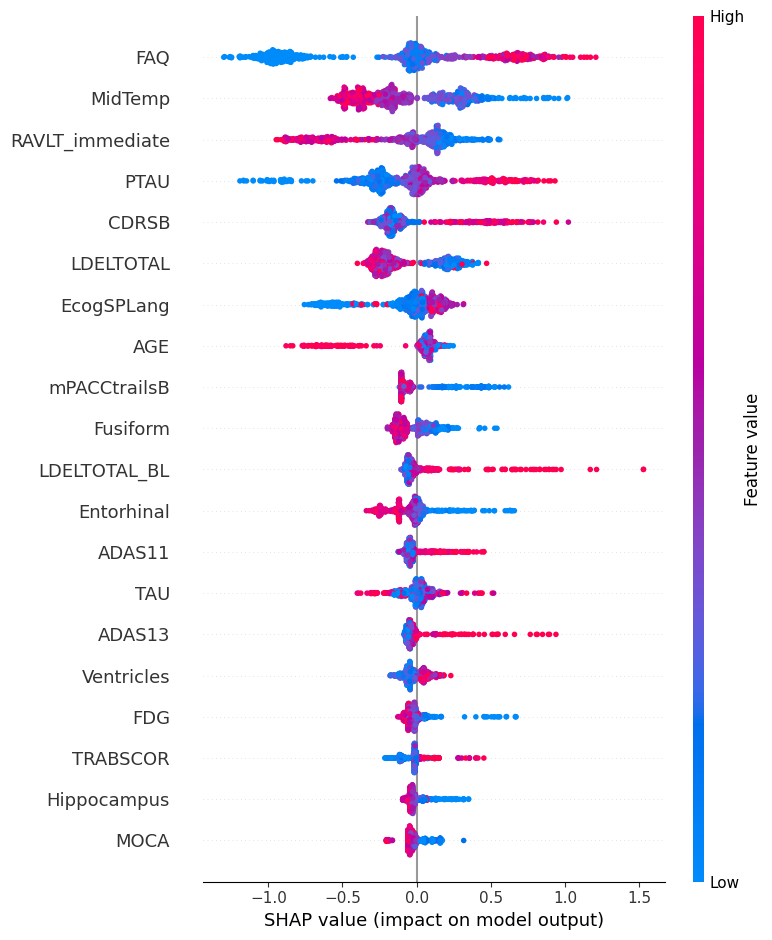

In [705]:
import shap
explainer = shap.TreeExplainer(mod_xgb)
shap_values = explainer(x_train)
#shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, max_display=20, show=False)
plt.savefig("output/xgb_shap.tiff", dpi=300)

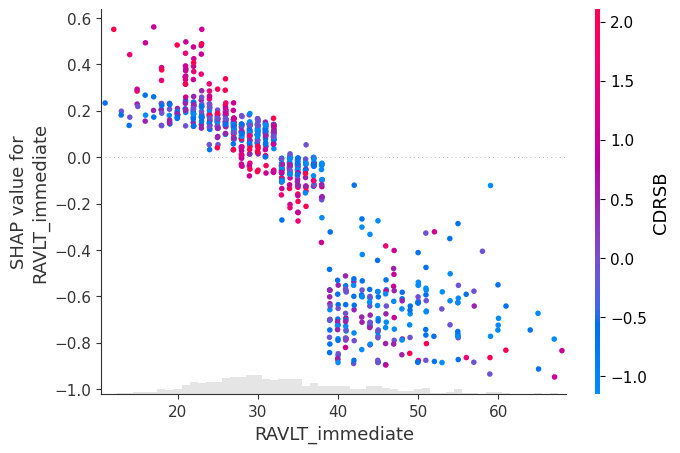

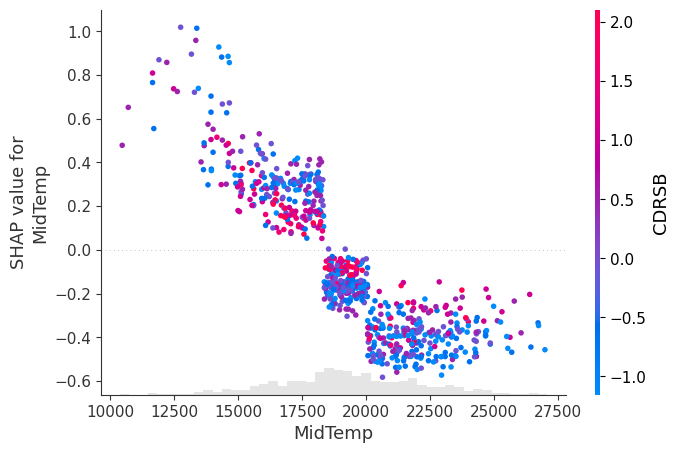

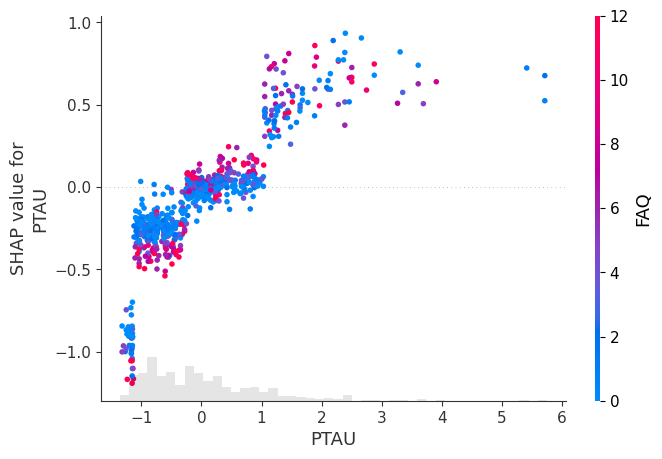

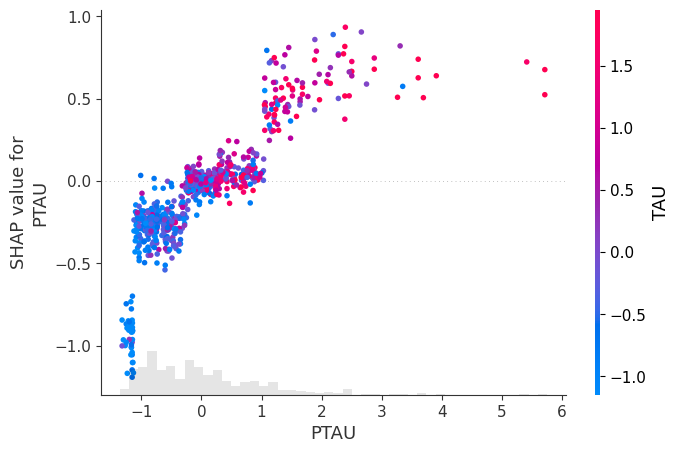

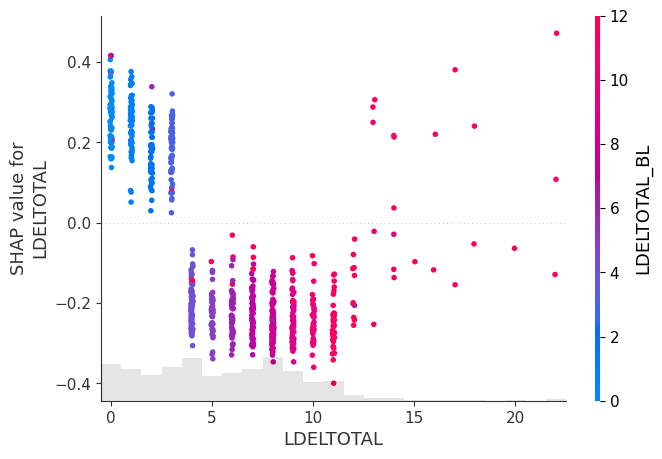

In [704]:
# explainer.shap_interaction_values(x_train)
#shap.dependence_plot("AGE", shap_values, x_train)
# shap_values.feature_names
# shap.plots.scatter(shap_values[:,"FAQ"], color=shap_values)
shap.plots.scatter(shap_values[:,"RAVLT_immediate"], color=shap_values, show=False)
plt.savefig("output/shap_interaction1.tiff", dpi=300)
shap.plots.scatter(shap_values[:,"MidTemp"], color=shap_values, show=False)
plt.savefig("output/shap_interaction2.tiff", dpi=300)
shap.plots.scatter(shap_values[:,"PTAU"], color=shap_values, show=False)
plt.savefig("output/shap_interaction3.tiff", dpi=300)
shap.plots.scatter(shap_values[:,"PTAU"], color=shap_values[:,"TAU"], show=False)
plt.savefig("output/shap_interaction4.tiff", dpi=300)
shap.plots.scatter(shap_values[:,"LDELTOTAL"], color=shap_values[:,"LDELTOTAL_BL"], show=False)
plt.savefig("output/shap_interaction5.tiff", dpi=300)


0      27
1      25
2      25
3      30
4      29
       ..
739    25
740    20
741    29
742    29
743    29
Name: MMSE, Length: 744, dtype: int64